# Байесовская статистика
## Задание BS.7


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---

* Задача 1 &mdash; 50 баллов
* Задача 2 &mdash; 10 баллов
* Задача 3 &mdash; 40 баллов

---

In [1]:
# Bot check

# HW_ID: ds_bs7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [100]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as sps

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
from bayes_opt import UtilityFunction

from matplotlib import gridspec
import seaborn as sns

sns.set(font_scale=1.4, style="whitegrid", palette="Set2")

from IPython import display
from time import sleep


import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time

__________________
### Задача 1.


Напишите класс регрессии на гауссовских процессах.

In [3]:
class GaussianProcessRegression:
    def __init__(self, cov_function):
        self.cov_function = cov_function

    def fit(self, X, Y, noise=1e-8):
        """
        Обучение модели регрессии на гауссовских процессах.
        X --- np.array, размерность (n, d):
            точки, в которых проведены измерения
        Y --- np.array, размерность n:
            полученные значения случайного поля
        """
        self.X = X
        self.Y = Y
        self.n = X.shape[0]

        X1 = X[:, None, :]          
        X2 = X[None, :, :]          
        self.C = np.vectorize(self.cov_function,
                              signature="(d)->()")(X1 - X2)
        self.C += noise * np.eye(self.n)
        self.C_inv = np.linalg.inv(self.C)
        return self

    def predict(self, X_star):
        """
        Оценка модели в новых точках X_star.
        X_star --- np.array, размерность (m, d)

        Возвращает:
            values --- np.array, размерность m: 
                предсказанные средние
            sigma2 --- np.array, размерность m:
                предсказанные дисперсии
        """
        r = np.vectorize(self.cov_function,
                         signature="(d)->()")(self.X[None, :, :] - X_star[:, None, :])
        values = r @ (self.C_inv @ self.Y)

        sigma = self.cov_function(np.zeros(self.n)) - np.diag(r @ (self.C_inv @ r.T))

        return values.ravel(), sigma

Зададим какую-нибудь простую функцию $f(x)$

In [4]:
def calc_f(x, a=0.2, b=0.5, c=2):
    return np.log(1+x) + a*x + b*np.sin(c*x)

И ковариационную функцию
$$R(x) = a\ exp\left(-\frac{\left\| x \right\|^2} {2s^2} \right),$$
где
* $x \in \mathbb{R}^d$;
* $a, s > 0$ &mdash; параметры.

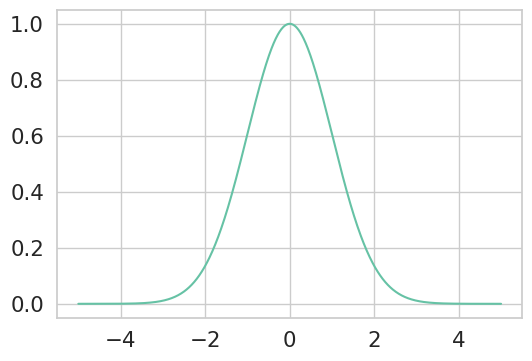

In [5]:
def exp_cov(x, a=1, s=1):
    return a * np.exp(-(x**2).sum(axis=-1) / (2 * s**2))

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

Проведем эксперименты.
Зададим гауссовский процесс $(Y_x, x\in\mathbb{R})$ в виде $Y_x = f(x) + \sigma\varepsilon_t$, где $(\varepsilon_x, x\in\mathbb{R})$ &mdash; гауссовский белый шум, то есть все $\varepsilon_x$ независимы и имеют стандартное нормальное распределение.

В качестве моментов времени $x_1, ..., x_n$ гененируем несколько точек на прямой.
Для начала возьмем $\sigma=0$, что соответствует отсутствию погрешности измерений.
Выполните код ниже.

<>:23: SyntaxWarning: invalid escape sequence '\w'
<>:23: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_75668/876708249.py:23: SyntaxWarning: invalid escape sequence '\w'
  plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')
/tmp/ipykernel_75668/2447597974.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(1+x) + a*x + b*np.sin(c*x)


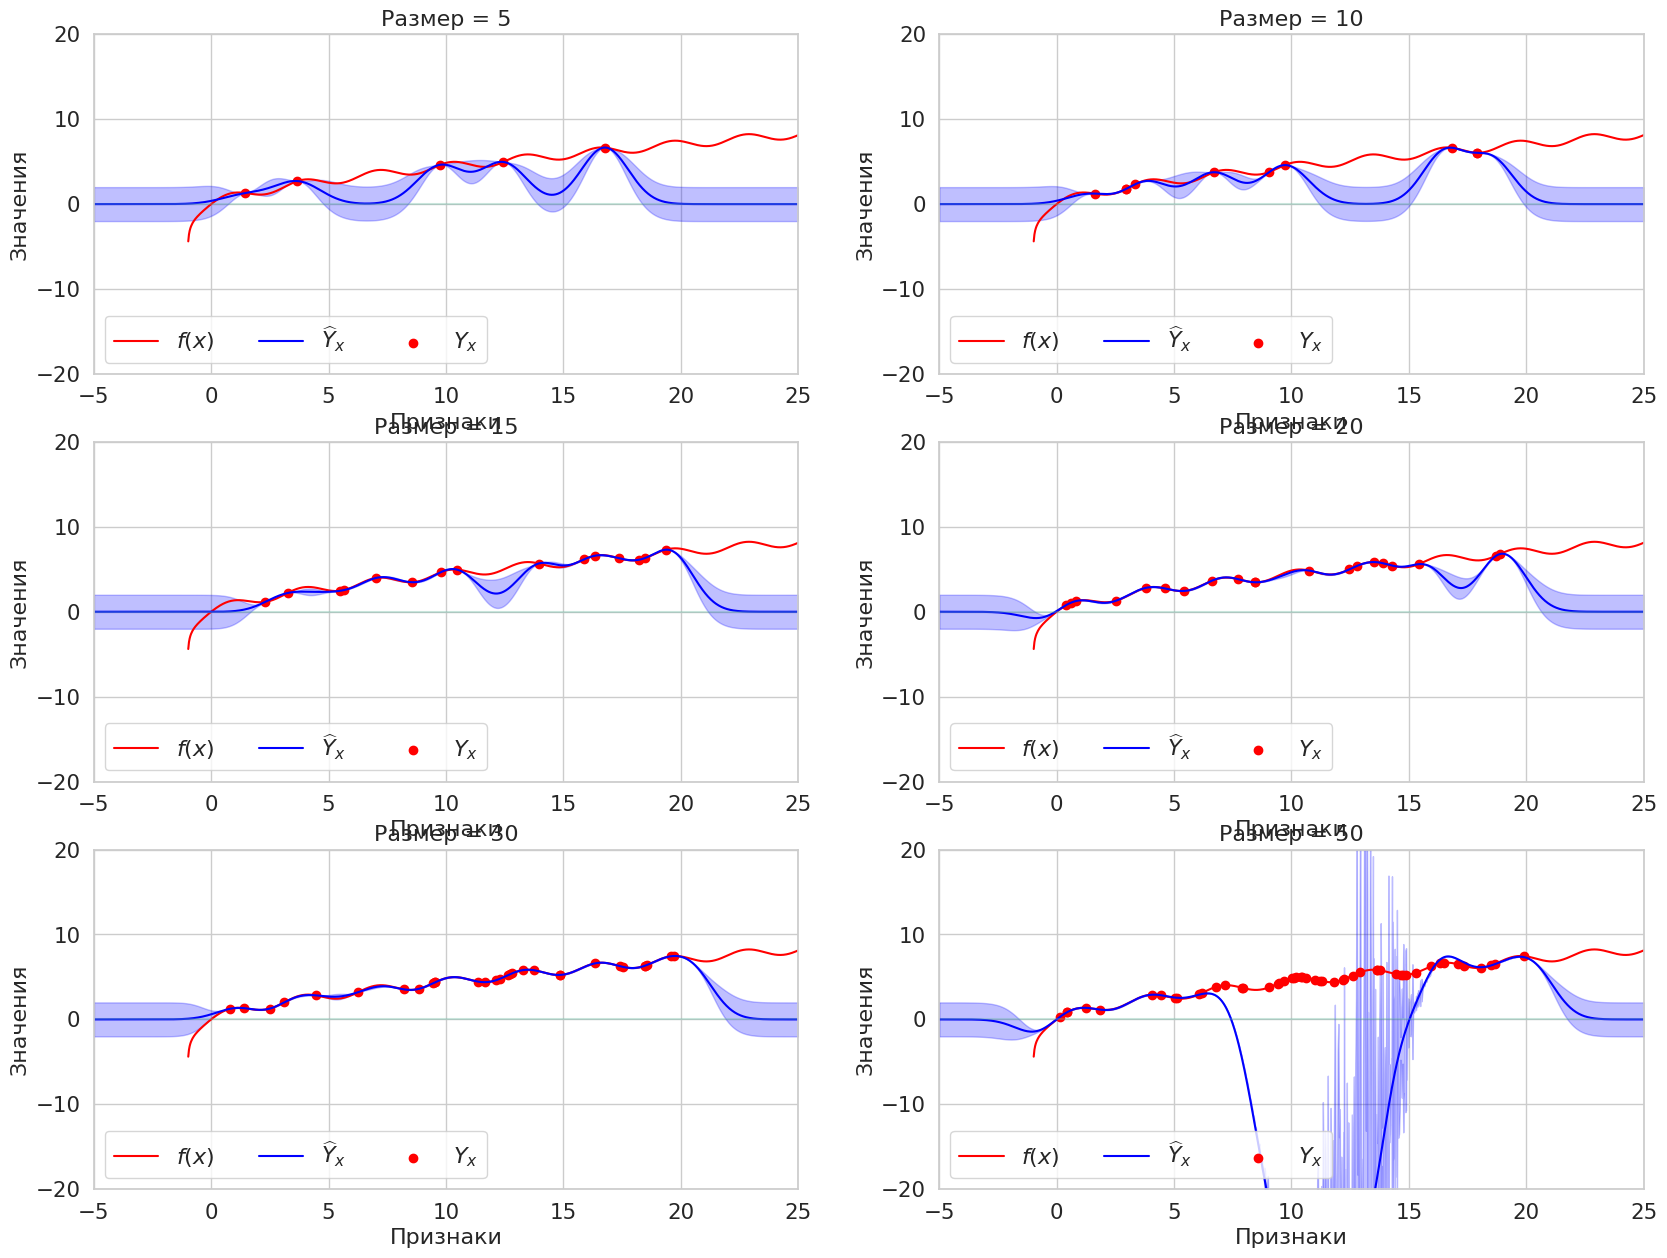

In [6]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    X = sps.uniform(loc=0, scale=20).rvs(size=size)
    Y = calc_f(X)

    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # Y += sps.norm(loc=0, scale=0.3).rvs(size=Y.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(X.reshape((-1, 1)), Y, noise=0)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(x)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(X, Y, color='red', label='$Y_x$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('Размер = {}'.format(size), fontsize=16)
    plt.xlabel('Признаки', fontsize=16)
    plt.ylabel('Значения', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Теперь предположим, что измерения проводятся с погрешностью, то есть $\sigma > 0$. Скопируйте код выше в новую ячейку, раскомментируйте строчку кода и запустите.

<>:23: SyntaxWarning: invalid escape sequence '\w'
<>:23: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_75668/1206837984.py:23: SyntaxWarning: invalid escape sequence '\w'
  plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')
/tmp/ipykernel_75668/2447597974.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(1+x) + a*x + b*np.sin(c*x)


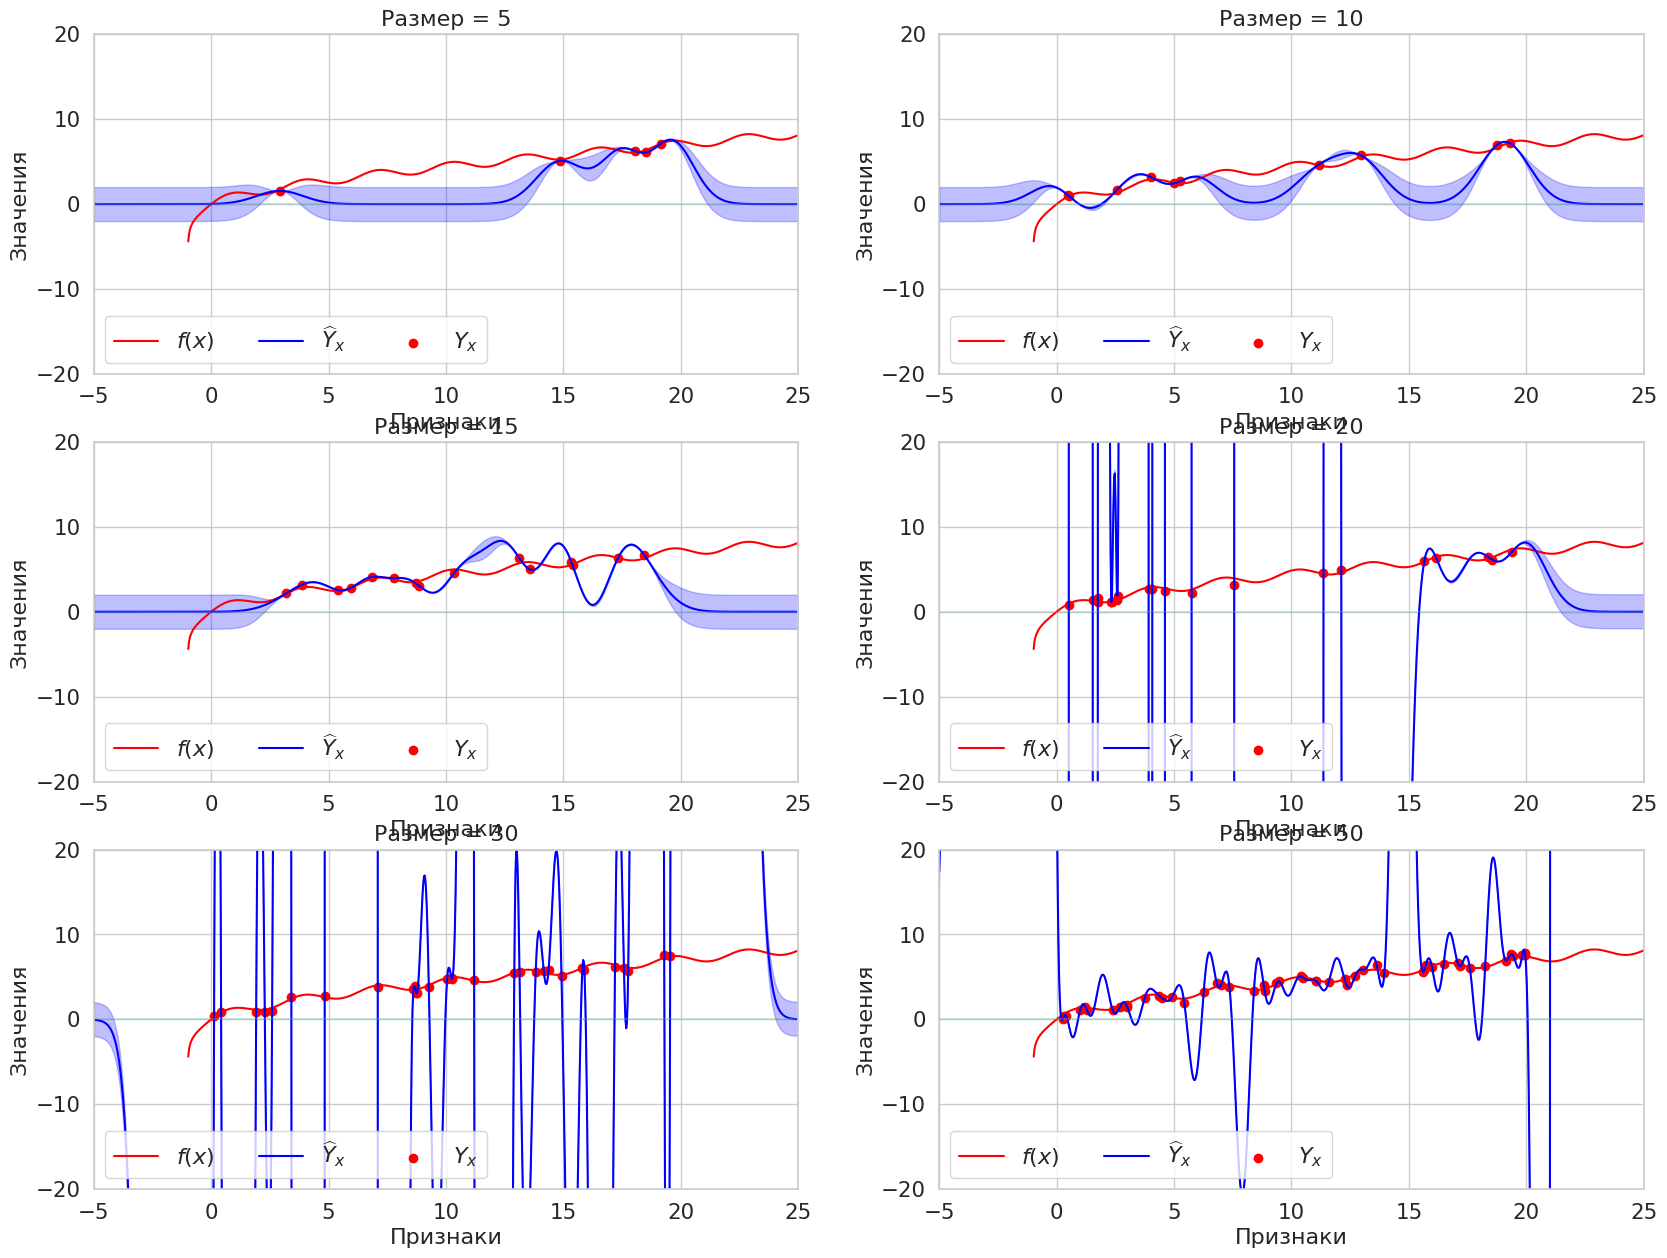

In [7]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    X = sps.uniform(loc=0, scale=20).rvs(size=size)
    Y = calc_f(X)

    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    Y += sps.norm(loc=0, scale=0.3).rvs(size=Y.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(X.reshape((-1, 1)), Y, noise=0)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(x)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(X, Y, color='red', label='$Y_x$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('Размер = {}'.format(size), fontsize=16)
    plt.xlabel('Признаки', fontsize=16)
    plt.ylabel('Значения', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему получается так плохо? Что нужно сделать, чтобы это исправить?

Когда мы инвертируем матрицу, то в силу мультиколлинеарности в ней появляются большие значения. Чтобы это исправить, можно добавлять шум перед инвертированием.

Исправьте это.

<>:23: SyntaxWarning: invalid escape sequence '\w'
<>:23: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_75668/2395878771.py:23: SyntaxWarning: invalid escape sequence '\w'
  plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')


/tmp/ipykernel_75668/2447597974.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(1+x) + a*x + b*np.sin(c*x)


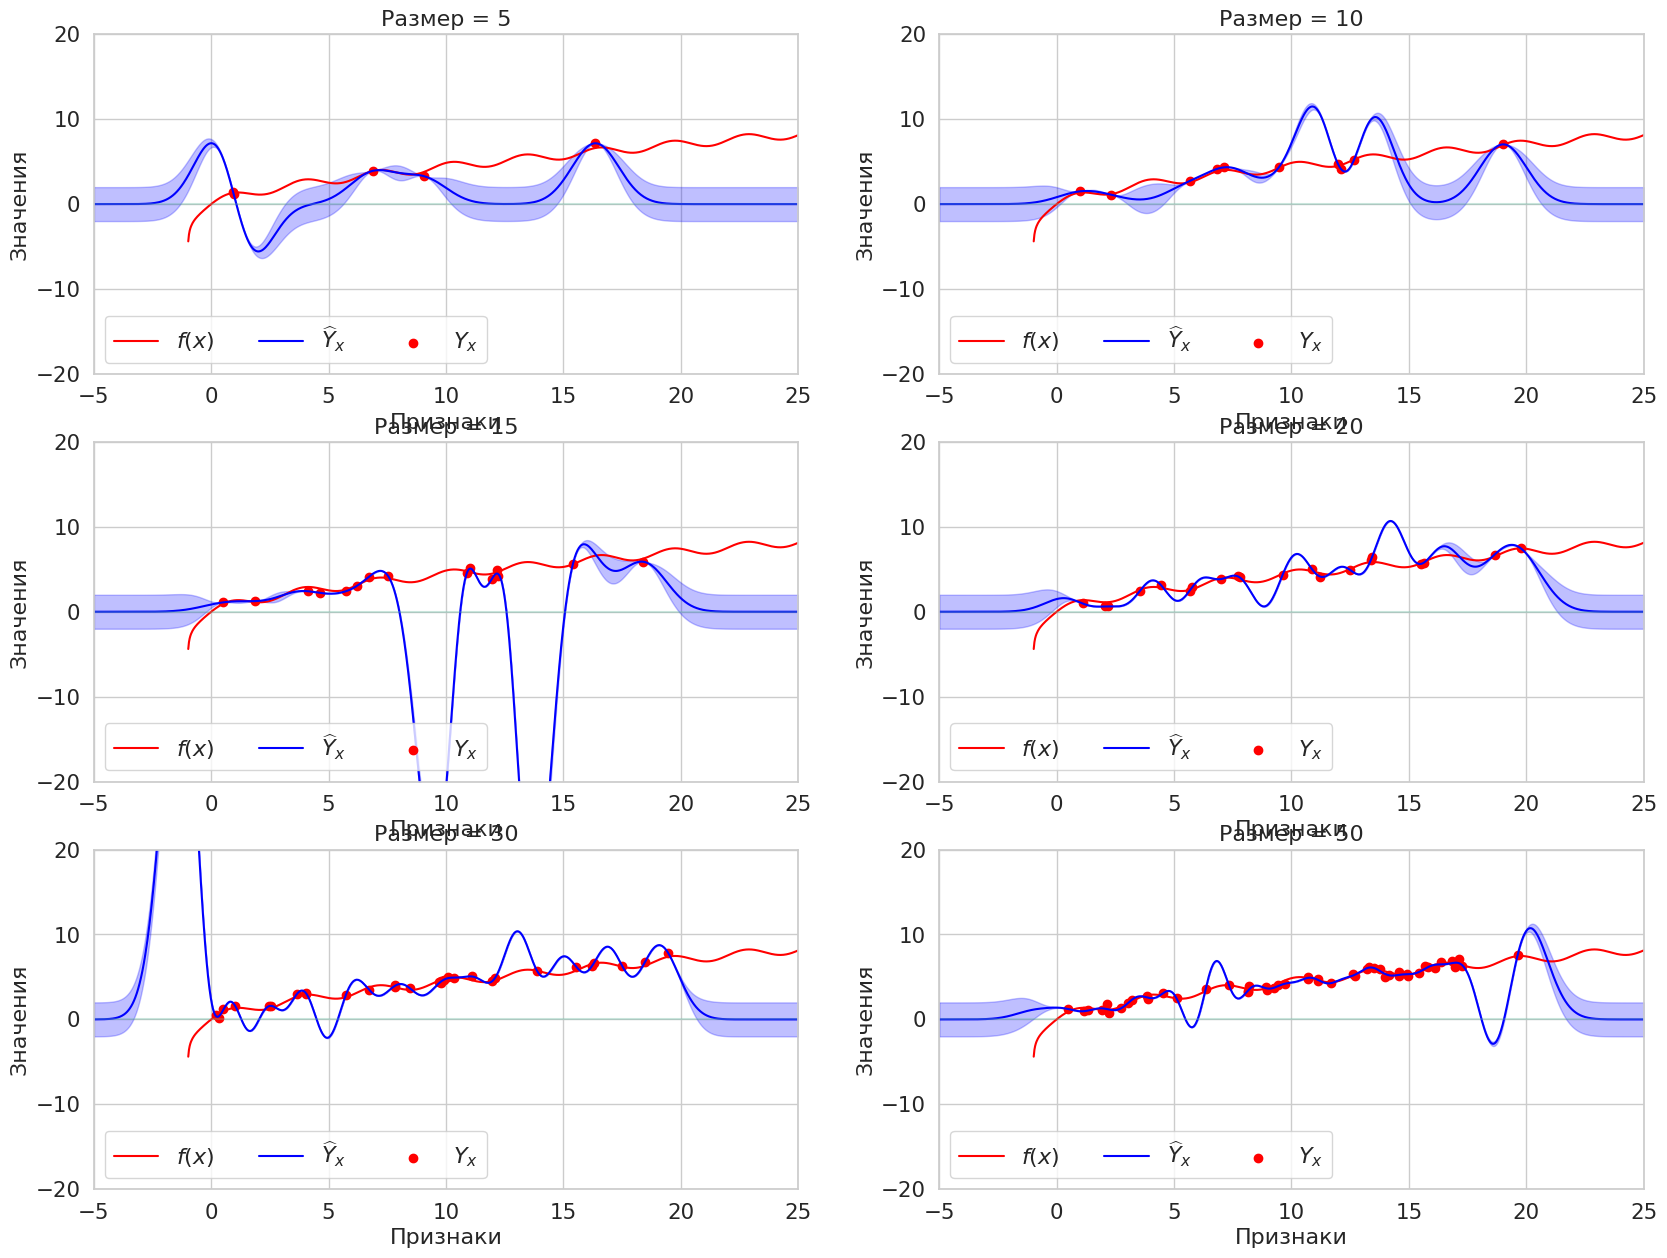

In [8]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    X = sps.uniform(loc=0, scale=20).rvs(size=size)
    Y = calc_f(X)

    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    Y += sps.norm(loc=0, scale=0.3).rvs(size=Y.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(X.reshape((-1, 1)), Y, noise=1e-5)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(x)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(X, Y, color='red', label='$Y_x$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('Размер = {}'.format(size), fontsize=16)
    plt.xlabel('Признаки', fontsize=16)
    plt.ylabel('Значения', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Почему стало лучше?

Потому что с добавлением шума мы избавились от мультиколлинеарности.

Однако, это все равно не поясняет, почему в самом первом случае (при $\sigma=0$) мог наблюдаться похожий эффект. В чем его причина?

Особенность функции, в силу чего появлялись внутренние зависимости.

Вспомним наше предположение о том, что математическое ожидание равно нулю, хотя на самом деле это не так.
Давайте это исправим.
В примере выше перед применением регрессии вычтете среднее значение, а после &mdash; добавьте обратно.

<>:27: SyntaxWarning: invalid escape sequence '\w'
<>:27: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_75668/2169245604.py:27: SyntaxWarning: invalid escape sequence '\w'
  plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')
/tmp/ipykernel_75668/2447597974.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(1+x) + a*x + b*np.sin(c*x)


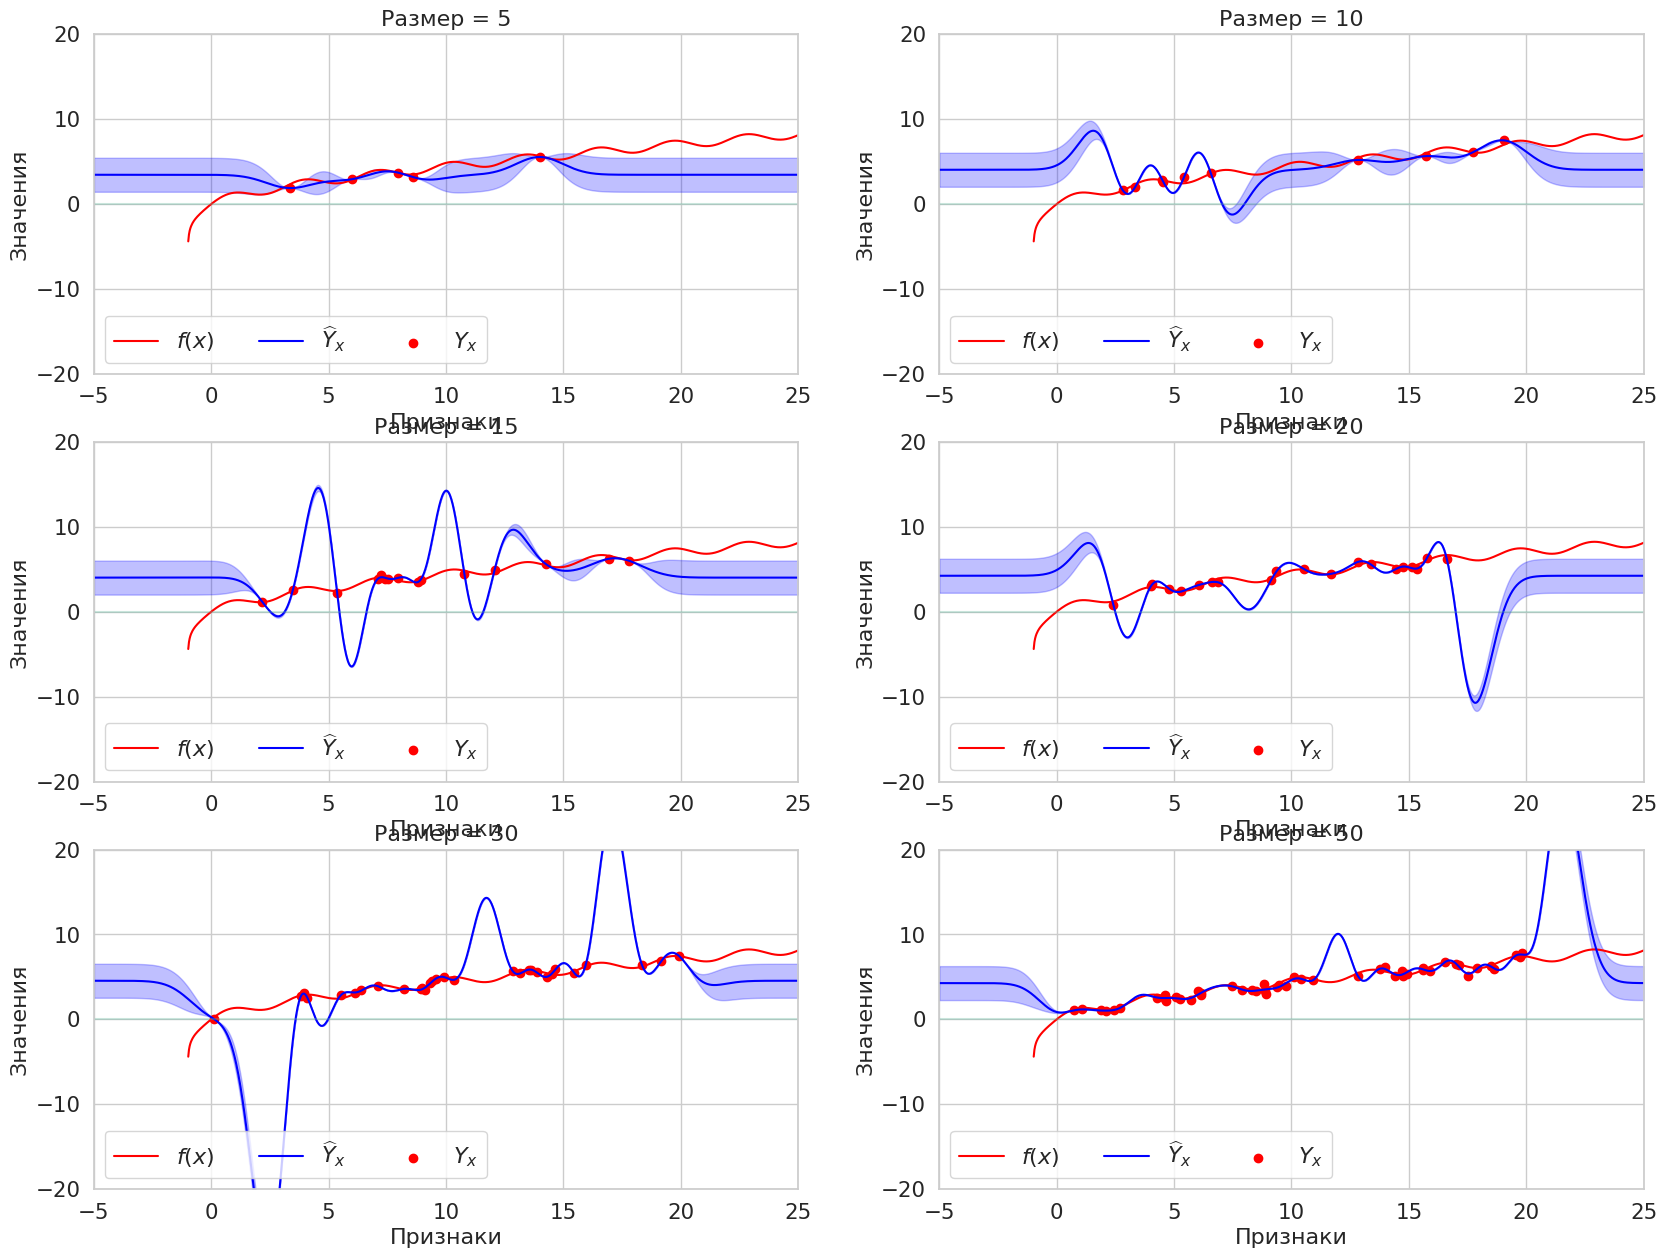

In [9]:
plt.figure(figsize=(20, 15))

# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    X = sps.uniform(loc=0, scale=20).rvs(size=size)
    Y = calc_f(X)

    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    Y += sps.norm(loc=0, scale=0.3).rvs(size=Y.shape)

    # Применение регрессии
    Y_mean = Y.mean()
    Y -= Y_mean
    gpr = GaussianProcessRegression(exp_cov).fit(X.reshape((-1, 1)), Y, noise=1e-5)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    predict += Y_mean
    Y += Y_mean
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(x)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{Y}_x$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(X, Y, color='red', label='$Y_x$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('Размер = {}'.format(size), fontsize=16)
    plt.xlabel('Признаки', fontsize=16)
    plt.ylabel('Значения', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Как видим, теперь участок где нет точек находится в среднем на уровне экспериментальной функции.

**Выводы:**

В данной задаче мы успешно написали класс гауссовской регрессии и применили его на практике, получив вполне удовлетворительные результаты.

__________________
### Задача 2.

Оптимизируйте следующую функцию при помощи байесовской оптимизации.

In [25]:
def target(x):
    return np.exp(-(x-2)**2) + np.exp(-(x-6)**2/10) + 1/ (x**2 + 1) \
                + sps.norm(scale=0.02).rvs(size=x.shape)

Посмотрим на то, как выглядит функция

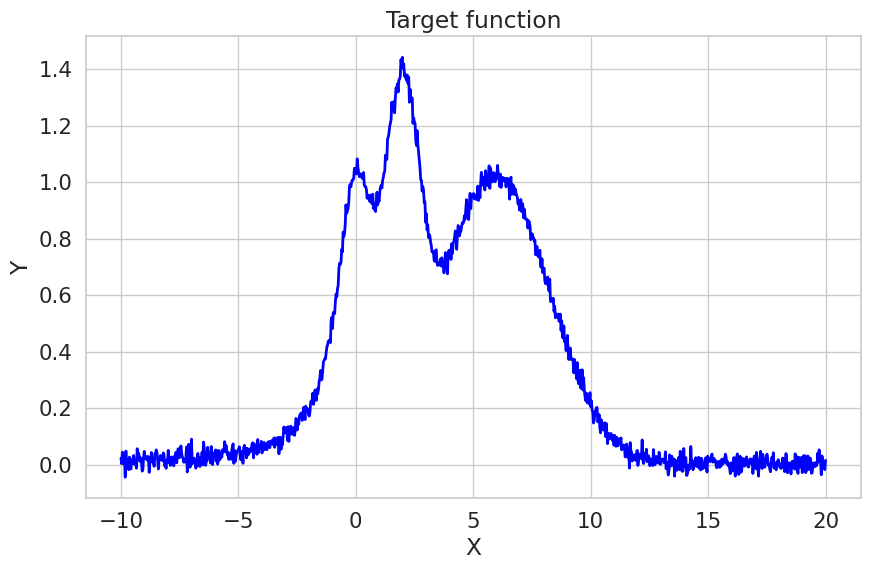

In [26]:
x = np.linspace(-10, 20, 1000)
y = target(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, color='b', linestyle='-', linewidth=2)
plt.title('Target function')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [80]:
optimizer = BayesianOptimization(target, {'x': (-5, 15)}, random_state=27)

Будем использовать верхнюю доверительную границу (UCB) в качестве функции полезности. Он имеет гиперпараметр κ, которые контролируют баланс между разведкой и эксплуатацией.

Установим κ=5

In [81]:
optimizer.maximize(init_points=20, n_iter=0, kappa=10)

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 0.7212    | 3.514     |
| 2         | 0.09995   | 11.29     |
| 3         | 0.2416    | 9.708     |
| 4         | 0.06927   | 12.36     |
| 5         | 1.104     | 2.668     |
| 6         | 0.01202   | 14.59     |
| 7         | 0.003306  | 12.86     |
| 8         | 0.6237    | -0.8057   |
| 9         | 0.2024    | 9.837     |
| 10        | 0.6108    | 8.263     |
| 11        | 0.01033   | 12.74     |
| 12        | 0.03961   | 12.16     |
| 13        | 0.2166    | 9.985     |
| 14        | 0.04619   | 12.4      |
| 15        | 0.4028    | -1.265    |
| 16        | 1.238     | 1.511     |
| 17        | 1.219     | 2.459     |
| 18        | 0.08703   | 10.87     |
| 19        | 0.2142    | -1.979    |
| 20        | 0.3095    | -1.601    |


/tmp/ipykernel_75668/2400153577.py:1: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  optimizer.maximize(init_points=20, n_iter=0, kappa=10)


In [82]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)
    grid_reshaped = grid.reshape(-1, 1)
    mu, sigma = optimizer._gp.predict(grid_reshaped, return_std=True)
    return mu, sigma

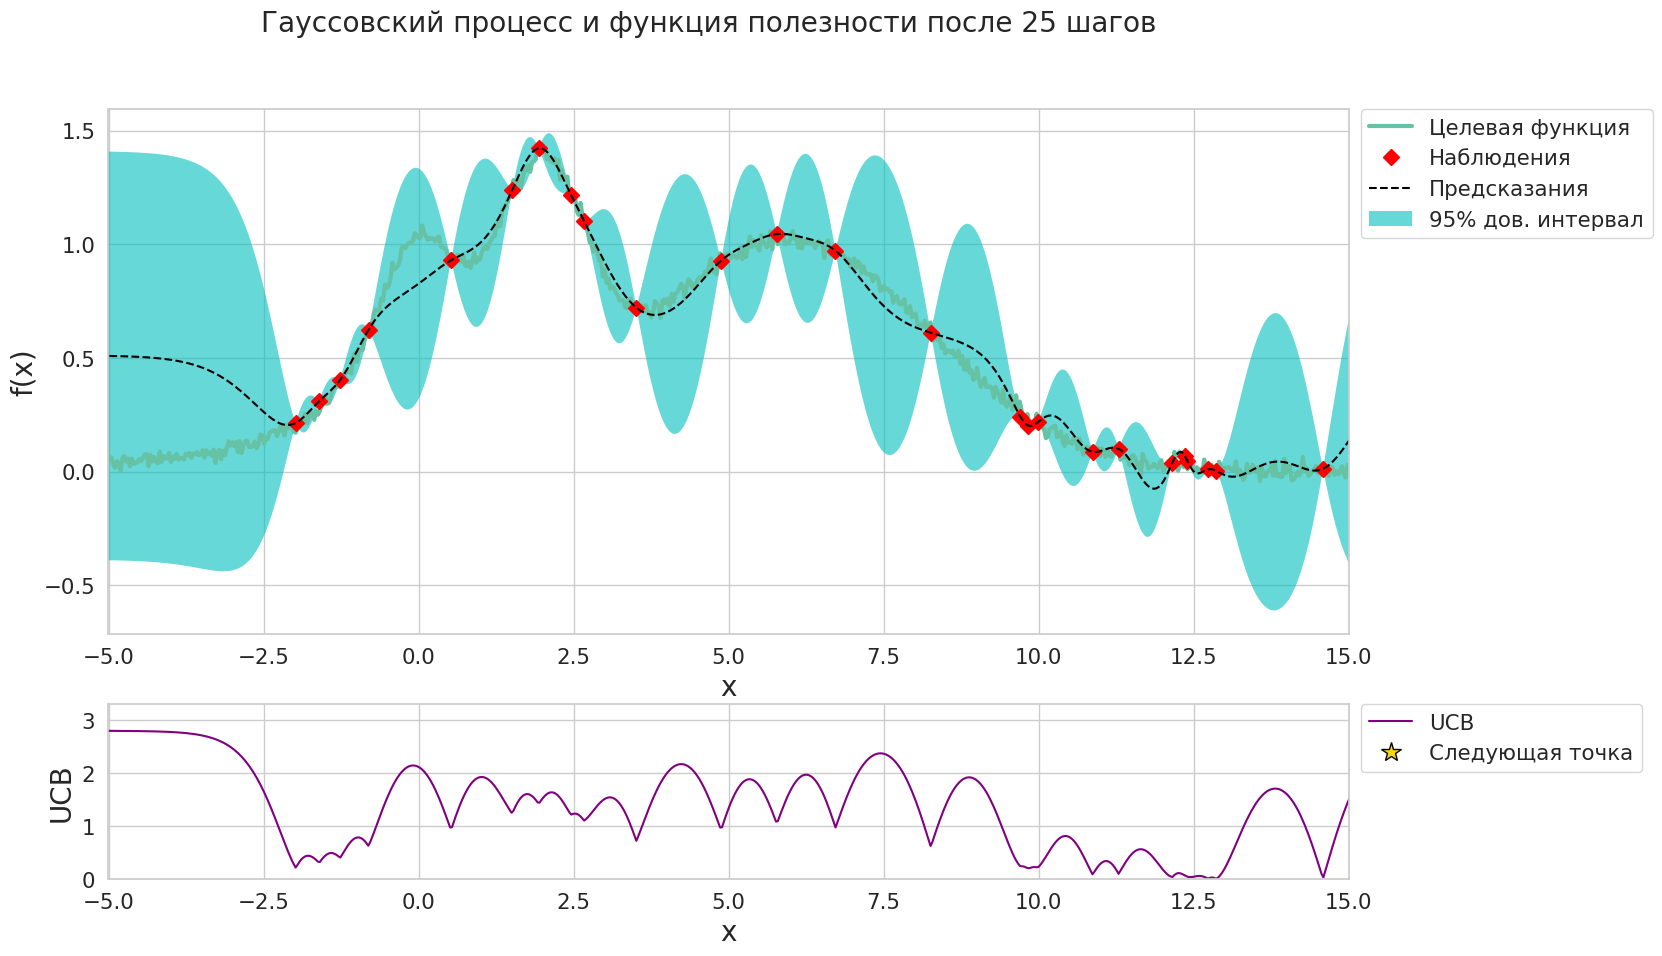

In [83]:
for i in range(5):
    sleep(0.3)

    optimizer.maximize(init_points=0, n_iter=1, kappa=10)

    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    steps = len(optimizer.space)

    display.clear_output(wait=True)
    plt.figure(figsize=(16, 10))
    plt.suptitle(
        "Гауссовский процесс и функция полезности после {} шагов".format(steps),
        fontdict={"fontsize": 20}, 
    )

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    axis.plot(x, y, linewidth=3, label="Целевая функция")
    axis.plot(x_obs.flatten(), y_obs, "D", markersize=8, label="Наблюдения", color="r")
    axis.plot(x, mu, "--", color="k", label="Предсказания")

    axis.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=0.6,
        fc="c",
        ec="None",
        label="95% дов. интервал",
    )

    axis.set_xlim((-5, 15))
    axis.set_ylim((None, None))
    axis.set_ylabel("f(x)", fontdict={"size": 20})
    axis.set_xlabel("x", fontdict={"size": 20})

    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x.reshape(-1, 1), optimizer._gp, 0)
    acq.plot(x, utility, label="UCB", color="purple")
    acq.plot(
        x[np.argmax(utility)],
        np.max(utility),
        "*",
        markersize=15,
        label="Следующая точка",
        markerfacecolor="gold",
        markeredgecolor="k",
        markeredgewidth=1,
    )
    acq.set_xlim((-5, 15))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel("UCB", fontdict={"size": 20})
    acq.set_xlabel("x", fontdict={"size": 20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.0)
    plt.show()

**Выводы:**

МЫ видим, что зоны между наблюдаемыми точками достаточно широкие, что может говорить о не лучшем выборе $\kappa$

__________________
### Задача 3.


Рассмотрите датасет `houses_train.csv` из задания 3.8 по машинному обучению с прошлого семестра. С помощью байесовской оптимизации подберите оптимальные гиперпараметров по метрике MAPE для модели `CatBoost`.

Рассмотрите следующие гиперпараметры:
* количество деревьев;
* максимальная глубина дерева;
* шаг обучения;
* параметры регуляризации.

Сколько итераций и времени занял процесс оптимизации?

In [101]:
data = pd.read_csv("houses_train.csv")
data["date"] = pd.to_datetime(data["date"], format="%Y%m%dT%H%M%S")
data["date"] = data["date"].astype("int64") // 86400 // 10**9
data["price"] = np.log(data["price"])


data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3392,16721,12.309982,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,18295,16778,13.195614,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,14569,16778,13.311329,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,14081,16849,13.142166,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,6725,16613,12.458775,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


In [102]:
X, y = data, data["price"]

ALPHA = 0.8

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ALPHA, random_state=42)

label_encoder = LabelEncoder()

X_train["zipcode_label"] = label_encoder.fit_transform(X_train["zipcode"])
X_test["zipcode_label"] = label_encoder.transform(X_test["zipcode"])

zipcode_price_mean = X_train.groupby("zipcode")["price"].mean()
X_train["zipcode_mean_encoding"] = X_train["zipcode"].map(zipcode_price_mean)
X_test["zipcode_mean_encoding"] = X_test["zipcode"].map(zipcode_price_mean)
X_test = X_test.drop("zipcode", axis=1)
X_train = X_train.drop("zipcode", axis=1)

X_train = X_train.drop("price", axis=1)
X_test = X_test.drop("price", axis=1)

In [103]:
def catboost_function(n_estimators, depth, log_lr, log_l2_reg):
    model = CatBoostRegressor(
        n_estimators=int(n_estimators),
        depth=int(depth),
        learning_rate=np.exp(log_lr),
        l2_leaf_reg=np.exp(log_l2_reg),
        random_seed=17,
        verbose=0,
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mape_test = mape(y_test, preds)
    
    return -mape_test

In [104]:
pbounds = {
    "n_estimators": (100, 1000),
    "depth": (3, 10),
    "log_lr": (-4, 0),
    "log_l2_reg": (-3, 3)
}

optimizer = BayesianOptimization(
    f=catboost_function,
    pbounds=pbounds,
    random_state=42,
)

start_time = time.time()
optimizer.maximize(
    init_points=10,  # сначала 10 случайных проб
    n_iter=100,       # потом 30 итераций по GP
    kappa=2.5        
)
end_time = time.time()

|   iter    |  target   |   depth   | log_l2... |  log_lr   | n_esti... |
-------------------------------------------------------------------------


/tmp/ipykernel_75668/1334729128.py:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  optimizer.maximize(


| 1         | -0.00989  | 5.622     | 2.704     | -1.072    | 638.8     |
| 2         | -0.00951  | 4.092     | -2.064    | -3.768    | 879.6     |
| 3         | -0.009424 | 7.208     | 1.248     | -3.918    | 972.9     |
| 4         | -0.009627 | 8.827     | -1.726    | -3.273    | 265.1     |
| 5         | -0.009385 | 5.13      | 0.1485    | -2.272    | 362.1     |
| 6         | -0.009404 | 7.283     | -2.163    | -2.831    | 429.7     |
| 7         | -0.009432 | 6.192     | 1.711     | -3.201    | 562.8     |
| 8         | -0.009904 | 7.147     | -2.721    | -1.57     | 253.5     |
| 9         | -0.01102  | 3.455     | 2.693     | -0.1375   | 827.6     |
| 10        | -0.01002  | 5.132     | -2.414    | -1.263    | 496.1     |
| 11        | -0.009388 | 5.804     | -0.1031   | -2.577    | 389.9     |
| 12        | -0.009298 | 6.086     | -1.012    | -3.495    | 929.4     |
| 13        | -0.009503 | 3.031     | -2.758    | -2.134    | 416.9     |
| 14        | -0.01295  | 9.796     | 

In [117]:
best_params = optimizer.max["params"]

print(f"Time taken: {end_time - start_time:.2f} seconds")
print(f"Iterations: {len(optimizer.res)}")

# Преобразуем обратно из логов
best_params["learning_rate"] = np.round(np.exp(best_params.pop("log_lr")), 4)
best_params["l2_leaf_reg"] = np.round(np.exp(best_params.pop("log_l2_reg")), 4)
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["depth"] = int(best_params["depth"])

print("Лучшие параметры:", best_params)
print(f"Лучший MAPE: { -optimizer.max['target'] * 100:.2f}%")

Time taken: 529.70 seconds
Iterations: 110
Лучшие параметры: {'depth': 6, 'n_estimators': 924, 'learning_rate': 0.0308, 'l2_leaf_reg': 0.0726}
Лучший MAPE: 0.93%


**Выводы:**

Мы видим, что благодаря байесовскому оптимизации нам удалось за небольшое количество итераций найти оптимальные параметры для CatBoostRegressor, а также оценить MAPE.

В частности, этот метод намного быстрее чем RandomizedSearchCV или GridSearchCV.